In [3]:
#!pip install scikit-commpy
#!pip install ipywidgets

In [4]:
#!pip install numpy


In [5]:
#!pip install matplotlib

In [6]:
#!pip install PyQt5
!pwd

/home/xy/projects/jupyter/signal_processing


In [7]:
from PyQt5.QtWidgets import *
from PyQt5.QtGui import *
from PyQt5.QtCore import Qt


In [8]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cmath
import math
from commpy.filters import rcosfilter
from ipywidgets import interact, widgets

In [9]:
from scipy.signal import butter, filtfilt
import os
from array import array
def read_signal(file_name, data_type):
    file_stats = os.stat(file_name)
    file_size = file_stats.st_size
    iq_size_in_bytes = 4
    number_of_int_to_read = file_size // iq_size_in_bytes * 2
    arr = array(data_type)
    with open(file_path, 'rb') as fileobj:
        arr.fromfile(fileobj, number_of_int_to_read)
    i = np.array(arr[:: 2])
    i = i.reshape((len(i), 1))
    q = np.array(arr[1:: 2])
    q = q.reshape((len(q), 1))
    sig = np.empty((len(i), 1), complex)
    sig.real = i
    sig.imag = q
    sig_flatten = sig.flatten()
    return sig_flatten


def find_carr_freq(spectrum, min_sig_lvl):
    idx = list(np.where(spectrum >= min_sig_lvl))
    idx = idx[0]
    f_low = idx[0]
    f_high = idx[-1]
    carr_freq = round((f_low + f_high) / 2)
    return carr_freq


def mixing_signal(signal, freq):
    N = len(signal)
    k = freq
    n = np.arange(0, N, 1)
    mixer = np.exp(-1j * 2 * math.pi * k * n / N)
    mixed_signal = np.multiply(signal, mixer)
    return mixed_signal


def filter_signal(mixed_sig, normal_cutoff):
    order = 2
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    sig_filtered = filtfilt(b, a, mixed_sig)
    return sig_filtered

In [10]:
def resampling_lagrange_step_ver(s, step, x0):
    """
    % y = resample_lagrange(s, p, q, x0)
    % Digital resampling by polynomial Lagrange interpolation.
    % Function changes input signal s samplerate to p/q times and adds fractional
    % delay.
    %
    % Input parameters
    %  s   - input signal vector [N x 1];
    %  p   - p paramter of samplarate conversion
    %  q   - q paramter of samplarate conversion
    %  x0  - fractional delay
    %
    % Ouptut parameters
    %  y   - Resampled signal
    %
    % Author: Sergey Bakhurin (dsplib.org)
    """
    #if (p > 1):
    #    if (q == 1):
    #        y = np.zeros(int(float((len(s) - 1) * p) / float(q)) + 1, dtype=np.csingle)
    #    else:
    #        y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)
    #else:
    #    y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)
    if (step > 1):
        y = np.zeros(int((len(s) -1) / step) + 1, dtype=np.csingle)
    else:
        y = np.zeros(int(len(s) / step), dtype=np.csingle) 
    
    t = np.zeros(len(y))
    s = np.concatenate((np.array([0., 0.]), s, np.array([0., 0.])))

    print(f"len(y) = {len(y)}, len(t) = {len(t)}, len(s) = {len(s)}")

    for k in range(len(y)):
        #x = k * q / p - x0
        x = k * step - x0
        t[k] = x
        n = int(np.floor(x)) + 4
        d = np.floor(x) + 1 - x
        #print(f"x = {x}, n = {n}, d = {d}")
        a0 = s[n - 1]
        a3 = 1 / 6 * (s[n] - s[n - 3]) + 0.5 * (s[n - 2] - s[n - 1])
        a1 = 0.5 * (s[n] - s[n - 2]) - a3
        a2 = s[n] - s[n - 1] - a3 - a1
        #print(f"a0 = {a0} a1 = {a1} a2 = {a2} a3 = {a3}")
        y[k] = a0 - a1 * d + a2 * d ** 2 - a3 * d ** 3

    #print(t)
    return y

In [11]:
n = np.arange(0, 20)
n[5] = 32767 
n[6] = 32767
n[7] = 32767
n[8] = 32767
n[9] =-32767
print(n)
s = resampling_lagrange_step_ver(n, 1.1, 0.9)
print(s)

[     0      1      2      3      4  32767  32767  32767  32767 -32767
     10     11     12     13     14     15     16     17     18     19]
len(y) = 18, len(t) = 18, len(s) = 24
[-1.6500000e-02+0.j  1.5200000e-01+0.j  1.3000000e+00+0.j
  2.4000001e+00+0.j -2.0441250e+03+0.j  1.9923961e+04+0.j
  3.4257715e+04+0.j  3.2767000e+04+0.j  3.4634719e+04+0.j
 -3.2767000e+04+0.j  9.4421600e+02+0.j  1.1200000e+01+0.j
  1.2300000e+01+0.j  1.3400000e+01+0.j  1.4500000e+01+0.j
  1.5600000e+01+0.j  1.6700001e+01+0.j  1.7799999e+01+0.j]


In [12]:
n = np.arange(0, 200, 1)
resampling_lagrange_step_ver(n, 3.2, 0.1)

len(y) = 63, len(t) = 63, len(s) = 204


array([-2.850e-02+0.j,  3.100e+00+0.j,  6.300e+00+0.j,  9.500e+00+0.j,
        1.270e+01+0.j,  1.590e+01+0.j,  1.910e+01+0.j,  2.230e+01+0.j,
        2.550e+01+0.j,  2.870e+01+0.j,  3.190e+01+0.j,  3.510e+01+0.j,
        3.830e+01+0.j,  4.150e+01+0.j,  4.470e+01+0.j,  4.790e+01+0.j,
        5.110e+01+0.j,  5.430e+01+0.j,  5.750e+01+0.j,  6.070e+01+0.j,
        6.390e+01+0.j,  6.710e+01+0.j,  7.030e+01+0.j,  7.350e+01+0.j,
        7.670e+01+0.j,  7.990e+01+0.j,  8.310e+01+0.j,  8.630e+01+0.j,
        8.950e+01+0.j,  9.270e+01+0.j,  9.590e+01+0.j,  9.910e+01+0.j,
        1.023e+02+0.j,  1.055e+02+0.j,  1.087e+02+0.j,  1.119e+02+0.j,
        1.151e+02+0.j,  1.183e+02+0.j,  1.215e+02+0.j,  1.247e+02+0.j,
        1.279e+02+0.j,  1.311e+02+0.j,  1.343e+02+0.j,  1.375e+02+0.j,
        1.407e+02+0.j,  1.439e+02+0.j,  1.471e+02+0.j,  1.503e+02+0.j,
        1.535e+02+0.j,  1.567e+02+0.j,  1.599e+02+0.j,  1.631e+02+0.j,
        1.663e+02+0.j,  1.695e+02+0.j,  1.727e+02+0.j,  1.759e+02+0.j,
      

In [13]:
def resampling_lagrange(s, p, q, x0):
    """
    % y = resample_lagrange(s, p, q, x0)
    % Digital resampling by polynomial Lagrange interpolation.
    % Function changes input signal s samplerate to p/q times and adds fractional
    % delay.
    %
    % Input parameters
    %  s   - input signal vector [N x 1];
    %  p   - p paramter of samplarate conversion
    %  q   - q paramter of samplarate conversion
    %  x0  - fractional delay
    %
    % Ouptut parameters
    %  y   - Resampled signal
    %
    % Author: Sergey Bakhurin (dsplib.org)
    """
    if (p > 1):
        if (q == 1):
            y = np.zeros(int(float((len(s) - 1) * p) / float(q)) + 1, dtype=np.csingle)
        else:
            y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)
    else:
        y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)

    t = np.zeros(len(y))
    s = np.concatenate((np.array([0., 0.]), s, np.array([0., 0.])))

    for k in range(len(y)):
        x = k * q / p - x0
        t[k] = x
        n = int(np.floor(x)) + 4
        d = np.floor(x) + 1 - x
        a0 = s[n - 1]
        a3 = 1 / 6 * (s[n] - s[n - 3]) + 0.5 * (s[n - 2] - s[n - 1])
        a1 = 0.5 * (s[n] - s[n - 2]) - a3
        a2 = s[n] - s[n - 1] - a3 - a1

        y[k] = a0 - a1 * d + a2 * d ** 2 - a3 * d ** 3

    return y


In [14]:
def calculate_spectrum(signal):
    yf = np.fft.fft(signal)
    yf = np.abs(yf.reshape((len(yf), 1))) / len(signal)
    return yf


def plot_spectrum(signal, figure_counter, title="Amplitude spectrum"):
    spectrum = np.roll(calculate_spectrum(signal), len(signal) // 2)
    yf = 20 * np.log10(spectrum)
    plt.figure(figure_counter)
    x_data = np.arange(-len(spectrum) // 2 + 1, len(spectrum) // 2 + 1)
    x_data = x_data / (len(spectrum) / 2)
    plt.plot(x_data, yf)
    plt.grid(1)
    plt.xlabel('Frequency (semicircles)')
    plt.ylabel('Magnitude (dB)')
    plt.title(title)
    return yf

In [15]:
def gen_rcfilter_impulse_response(n, fs):
    s_psf = rcosfilter(n * fs, alpha=0.24, Ts=1, Fs=fs)[1][1:]
    print(s_psf)
    plt.figure()
    plt.plot(s_psf, '*-')
    plt.grid()
    plt.title('RC filter impulse response')
    plt.show()
    return s_psf

In [16]:
def add_freq(sig, f0_to_fsig):
    n = np.arange(0, len(sig), 1)
    j_exp = np.exp(1j * np.pi * f0_to_fsig * n)
    print("complex exp")
    print(j_exp[0 : 20])
    mixer = np.exp(1j * np.pi * f0_to_fsig * n)
    return sig * mixer

In [17]:
def add_phase(sig, phase):
# phase = [-1, 1] [semicircles]
    sig *= np.exp(1j * np.pi * phase)
    return sig

In [18]:
def gen_qpsk_symbols(n_symb, fs):
    # create IQ of QPSK
    # complex array: [(1 + 1j, 1 -1j, ..., -1 -1j)]
    data = np.random.randint(0, 4, n_symb)
    #x_tr = x.transpose()
    y = [-1 - 1j, -1 + 1j, 1 - 1j, 1 + 1j]
    iq = [y[val] for val in data]
    iq_ups = np.zeros(N * fs, dtype=complex)
    iq_ups[:len(iq) * fs:fs] = iq
    return iq_ups

[ 4.24996460e-06  7.80681981e-06  1.00473518e-05  1.06096386e-05
  9.46490890e-06  6.91708197e-06  3.53015446e-06 -1.42863282e-19
 -3.00015110e-06 -4.96525263e-06 -5.66180926e-06 -5.16569850e-06
 -3.82639780e-06 -2.16685201e-06 -7.43433574e-07  4.61964924e-21
 -1.51629103e-07 -1.12674664e-06 -2.58256731e-06 -3.99121783e-06
 -4.77670319e-06 -4.47010141e-06 -2.84513962e-06 -4.16635826e-20
  3.63686506e-06  7.38161233e-06  1.04361963e-05  1.20652840e-05
  1.17688807e-05  9.41035207e-06  5.26863180e-06 -1.79753096e-19
 -5.48480673e-06 -1.02028862e-05 -1.33015042e-05 -1.42357985e-05
 -1.28820258e-05 -9.56057570e-06 -4.96312666e-06  2.40699928e-20
  4.39801342e-06  7.47858044e-06  8.82247665e-06  8.41908649e-06
  6.64619334e-06  4.15978944e-06  1.72072998e-06 -5.96968215e-20
 -5.90424284e-07  7.73447676e-20  1.45009430e-06  3.15227033e-06
  4.37379020e-06  4.45551562e-06  2.99972529e-06 -8.23022442e-20
 -4.12112841e-06 -8.57986133e-06 -1.23923623e-05 -1.45949744e-05
 -1.44736440e-05 -1.17488

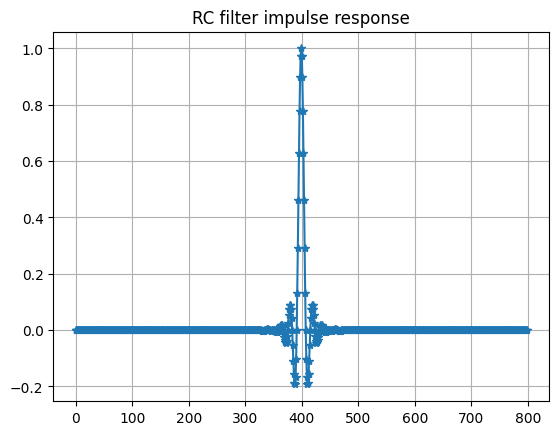

len(y) = 888, len(t) = 888, len(s) = 804
complex exp
[ 1.00000000e+00+0.00000000e+00j  5.55570233e-01+8.31469612e-01j
 -3.82683432e-01+9.23879533e-01j -9.80785280e-01+1.95090322e-01j
 -7.07106781e-01-7.07106781e-01j  1.95090322e-01-9.80785280e-01j
  9.23879533e-01-3.82683432e-01j  8.31469612e-01+5.55570233e-01j
  3.06161700e-16+1.00000000e+00j -8.31469612e-01+5.55570233e-01j
 -9.23879533e-01-3.82683432e-01j -1.95090322e-01-9.80785280e-01j
  7.07106781e-01-7.07106781e-01j  9.80785280e-01+1.95090322e-01j
  3.82683432e-01+9.23879533e-01j -5.55570233e-01+8.31469612e-01j
 -1.00000000e+00+6.12323400e-16j -5.55570233e-01-8.31469612e-01j
  3.82683432e-01-9.23879533e-01j  9.80785280e-01-1.95090322e-01j]


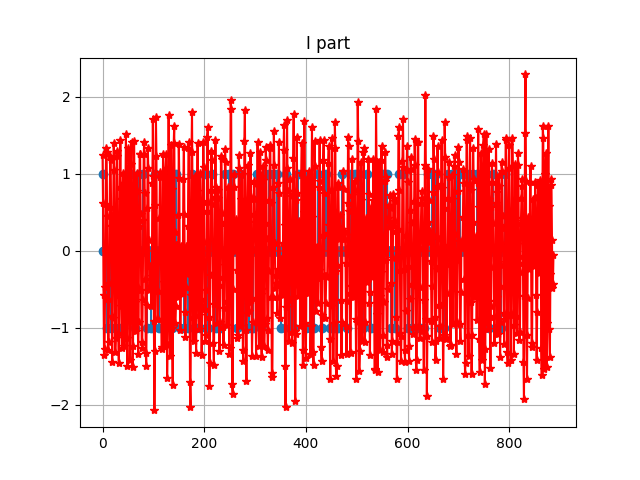

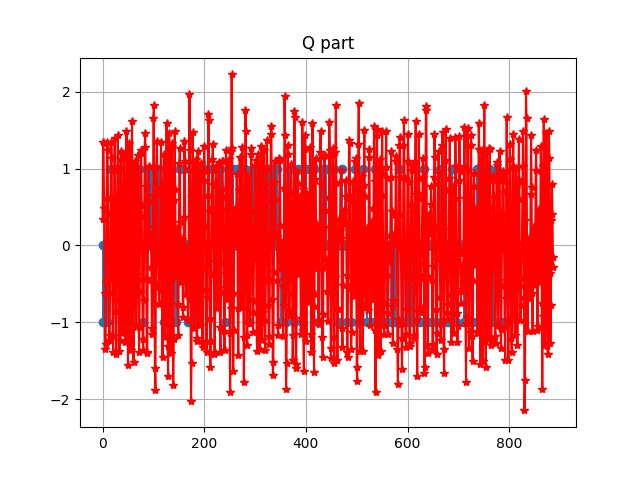

In [19]:
N = 100
Fs = 8 # f_sampling / f_symbol (SPS)
f0 = 2.5 # f_carrier / f_symbol
phase_0 = 3 / 9 # semicircles
delay = 0.1

s_rc = gen_rcfilter_impulse_response(N, Fs)
s_qpsk = gen_qpsk_symbols(N, Fs)
qpsk_filtered = np.convolve(s_qpsk, s_rc, 'same')
# ----- Add delay -----
p = 1
q = 1
x0 = delay # it is negative delay
global s_rc_re_delay 
#lobal qpsk_filtered
qpsk_filtered = resampling_lagrange_step_ver(qpsk_filtered, 0.9, 0.1)
#qpsk_filtered = resampling_lagrange(qpsk_filtered, p, q, x0) # qpsk_filt_del

# ----- Add Carrier and initial phase -----
qpsk_filtered = add_phase(qpsk_filtered, phase_0)
qpsk_filtered = add_freq(qpsk_filtered, f0 / Fs)

import ipympl
%matplotlib inline
%matplotlib widget
plt.figure()
plt.stem(s_qpsk.real)
plt.plot(qpsk_filtered.real, 'r*-')
plt.grid()
plt.title('I part')
plt.show()


plt.figure()
plt.stem(s_qpsk.imag)
plt.plot(qpsk_filtered.imag, 'r*-')
plt.grid()
plt.title('Q part')
plt.show()

#s_rc_conv = np.convolve(s_qpsk_with_carr, s_rc, 'same')


In [20]:
def plot_iq( delay: float, fsymb_to_fsampl: float, phase: float, f0: float):
    print(f"fract omega = {f0}, fsymb_to_fsampl = {fsymb_to_fsampl}, phase = {phase}")
    matplotlib.pyplot.close()

    signal_iq = qpsk_filtered
    
    mixed_sig = add_freq(signal_iq, f0)
    sig_default = add_phase(mixed_sig, phase)

    p = 1
    q = round(fsymb_to_fsampl) #todo -> remove round()
    x0 = delay
    print(f"p = {p}, q = {q}, x = {x0}")
    res_sig = resampling_lagrange_step_ver(sig_default, fsymb_to_fsampl, x0)
    #res_sig = resampling_lagrange(sig_default, p, q, x0)
    plt.close()
    plt.figure()
    plt.plot(res_sig.real, res_sig.imag, '.')
    plt.grid()
    plt.show()

In [21]:
delay_float = widgets.BoundedFloatText(
    value=0,
    min=-1,
    max=1,
    step=0.0001,
    description='Delay before first symbol, samples:',
    disabled=False
)

sps = widgets.BoundedFloatText(
    value=1.0,
    min=1,
    max=50,
    step=0.00001,
    description='SPS',
    disabled=False
)

phase_float = widgets.BoundedFloatText(
    value=.0,
    min=-1,
    max=1,
    step=0.0001,
    description='Phase, [-1, 1], semicircles',
    disabled=False
)

f0_float = widgets.BoundedFloatText(
    value=.0,
    min = -1,
    max = 1,
    step = 0.0001,
    description = 'f0, [0, 1], circles',
    disabled = False
)
#print(qpsk_filtered)

# Use the interact function to connect the slider to the plot function
interact(plot_iq, delay=delay_float, fsymb_to_fsampl=sps, phase = phase_float, f0 = f0_float)

interactive(children=(BoundedFloatText(value=0.0, description='Delay before first symbol, samples:', max=1.0, …

<function __main__.plot_iq(delay: float, fsymb_to_fsampl: float, phase: float, f0: float)>

In [49]:
# Check samples.pcm
import numpy as np
import struct
import os
def read_by_unpack(file_name, data_num=0, data_type="int16"):
    # Load test data (int16, float32
    
    f = open(file_name,'rb')
    file_stats = os.stat(file_name)
    file_size = file_stats.st_size
    print(file_size)
    sizeof_data = 0
    struct_type = ''
    if data_type == "int16":
        sizeof_data = 2
        struct_type = 'h'
    if data_type == "float32":
        sizeof_data = 4
        struct_type = 'f'
    
    if data_num == 0:
        data_num = int(file_size / sizeof_data);
    
    #  102500 is the number of numbers contained in the document, and a floating point number occupies 4 bytes
    arr = f.read(data_num * sizeof_data)
    print(data_num)
    data_raw = struct.unpack(struct_type * data_num, arr)
    f.close()
    return data_raw

def read_signal(file_name, data_type, int_num_to_read = 0):
    file_stats = os.stat(file_name)
    file_size = file_stats.st_size
    iq_size_in_bytes = 0
    if data_type == 'h':
        iq_size_in_bytes = 4
    if data_type == 'f':
        iq_size_in_bytes = 8
    if int_num_to_read == 0:
        int_num_to_read = file_size // iq_size_in_bytes * 2
    else:
        int_num_to_read += (int_num_to_read % 2)
    print(int_num_to_read)     
    arr = array(data_type)
    with open(file_name, 'rb') as fileobj:
        arr.fromfile(fileobj, int_num_to_read)
        dd = struct.unpack('>' + data_type, arr)[0]
    i = np.array(arr[:: 2])
    i = i.reshape((len(i), 1))
    q = np.array(arr[1:: 2])
    q = q.reshape((len(q), 1))
    print(i[:10])
    sig = np.empty((len(i), 1), complex)
    sig.real = i
    sig.imag = q
    sig_flatten = sig.flatten()
    return sig_flatten

def read_float_by_unpack_delimeter(file_name, data_type, data_num=0, shift=0, separator='\n'):
    # Load test data
    
    #f = open(file_name,'rb')
    file_stats = os.stat(file_name)
    file_size = file_stats.st_size
    #print(file_size)
    if data_num == 0:
        if data_type == 'float32':
            data_num = int(file_size / 4)
        if data_type == 'int16':
            data_num = int(file_size / 2)

    if data_type == 'float32':
        t = np.float32
    if data_type == 'int16':
        t = np.int16
    
    
    # Open the binary file using a file object
    print("data num")
    print(data_num)
    print(t)
    
    with open(file_name, 'rb') as file:
    # Read the binary data and convert it to a NumPy array
        data = np.fromfile(file, dtype=t, count=data_num, offset=shift, sep=separator)

    #with open(file_name, 'rb') as f:
     #   for line in f.readlines():
            # Each line represents a binary float, strip the newline and unpack
      #      number = struct.unpack('f', line.strip())[0]
       #     data_raw[i] = number
    
    #print("data num ")
    #print(data_num)
    #  102500 is the number of numbers contained in the document, and a floating point number occupies 4 bytes
    #arr = f.read(data_num * 4)
    #data_raw = struct.unpack('f'*data_num, arr)
    
    return data

def calculate_spectrum(signal):
    yf = np.fft.fft(signal)
    yf = np.abs(yf.reshape((len(yf), 1))) / len(signal)
    return yf


def plot_spectrum(signal, figure_counter, title="Amplitude spectrum"):
    spectrum = np.roll(calculate_spectrum(signal), len(signal) // 2)
    yf = 20 * np.log10(spectrum)

    plt.figure(figure_counter)
    plt.cla()
    x_data = np.arange(-len(spectrum) // 2 + 1, len(spectrum) // 2 + 1)
    x_data = x_data / (len(spectrum) / 2)
    plt.plot(x_data, yf)
    plt.grid(1)
    plt.xlabel('Frequency (semicircles)')
    plt.ylabel('Magnitude (dB)')
    plt.title(title)
    plt.show()
    return yf

def plot_signal_power(signal, figure_counter, title="Signal Power"):
    plt.figure(figure_counter)
    plt.cla()
    x_data = np.arange(0, len(signal))
    plt.plot(x_dasta, signal)
    plt.grid(1)
    plt.xlabel('time (samples)')
    plt.ylabel('Signal Power')
    plt.title(title)
    plt.show()
    
def make_cmplx_sig(iq_data):
    i = np.array(iq_data[:: 2])
    i = i.reshape((len(i), 1))
    q = np.array(iq_data[1:: 2])
    q = q.reshape((len(q), 1))
    print(i[:10])
    sig = np.empty((len(i), 1), complex)
    sig.real = i
    sig.imag = q
    sig_flatten = sig.flatten()
    return sig_flatten

data num
20000
<class 'numpy.int16'>
[[16209]
 [17519]
 [18363]
 [18755]
 [18764]
 [18488]
 [18044]
 [17548]
 [17101]
 [16782]]
[16209.-18267.j 17519.-15166.j 18363.-10586.j 18755. -4961.j
 18764. +1113.j 18488. +6961.j 18044.+11909.j 17548.+15370.j
 17101.+16925.j 16782.+16373.j 16625.+13777.j 16614. +9462.j
 16712. +3959.j 16860. -2053.j 16991. -7835.j 17047.-12673.j
 16992.-15977.j 16826.-17334.j 16573.-16580.j 16276.-13811.j
 16004. -9340.j 15839. -3665.j 15854. +2610.j 16099. +8853.j
 16589.+14483.j 17285.+19031.j 18111.+22207.j 18959.+23921.j
 19678.+24260.j 20096.+23463.j]


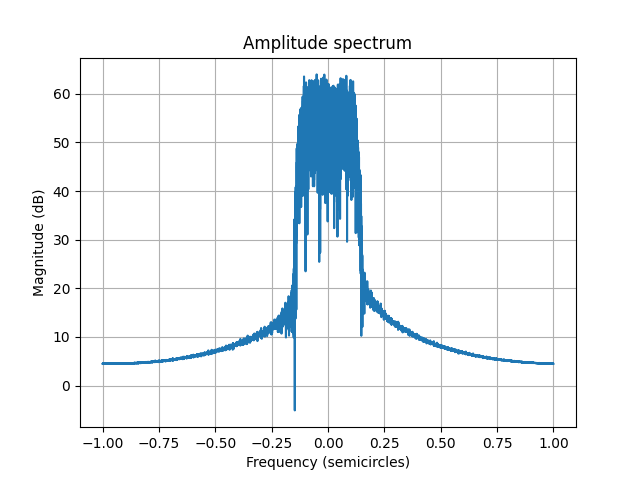

array([[4.49742735],
       [4.51911765],
       [4.53712198],
       ...,
       [4.49054262],
       [4.51252008],
       [4.47620245]])

In [67]:
  
# 1: Source signal
#plt.close()    
#file_path = "/home/xy/Documents/samples.pcm"
file_path = "/home/xy/cuda_filt_sig_int16.pcm" #Documents/linkstar_625kbaud_fs_1250kHz.pcm"
file_path = "qpsk_rc_int16_1_sig.bin"
data_type = "int16"
figure_counter = 0
source_samples = read_float_by_unpack_delimeter(file_path, 'int16', 20000, 0, '')
source_signal = make_cmplx_sig(source_samples)
print(source_signal[:30])
#source_signal_full = read_signal(file_path, 'h', 20000)
plot_spectrum(source_signal, 0)

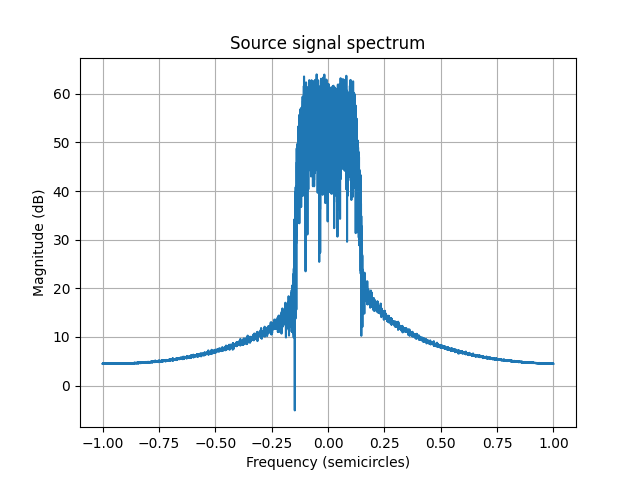

f_carr = 0


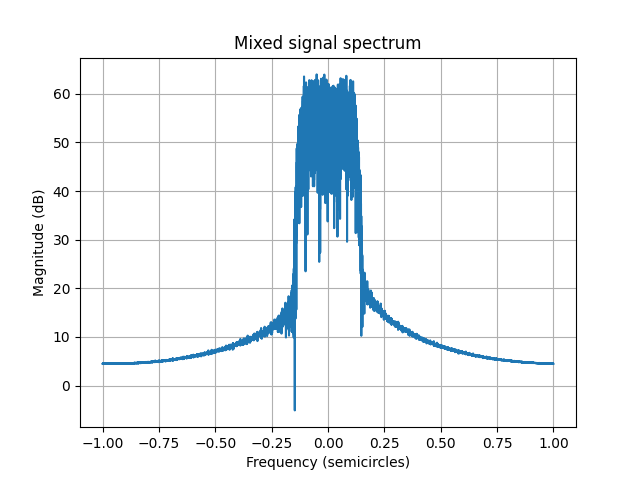

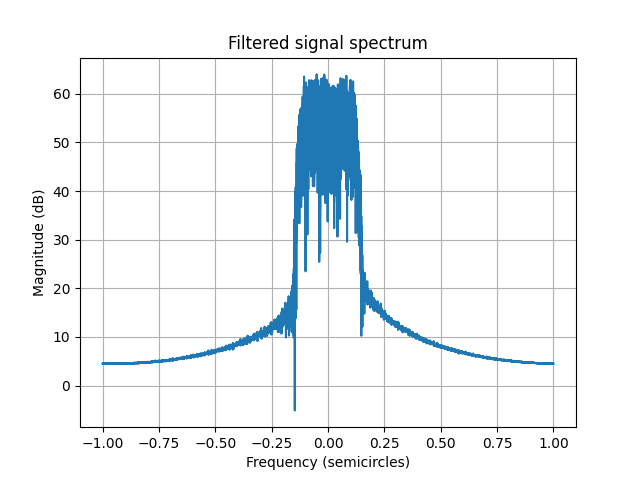

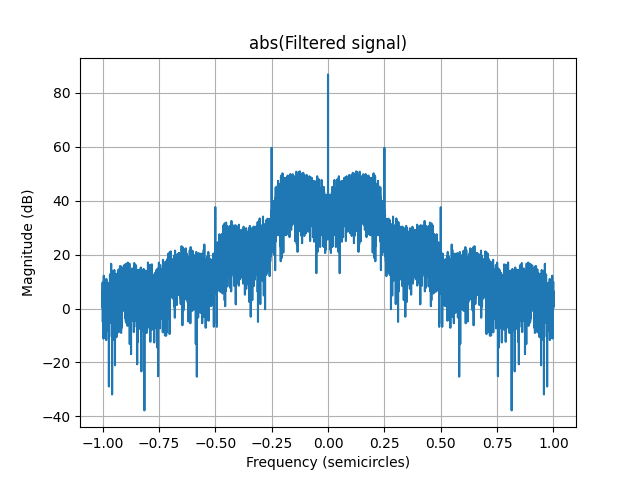

0.125
0.875
0.0625
0.9375
0.9299
Symbol rate:  0.12500 * F_s


In [68]:
#source_signal = source_signal_full[int(2.0e7):int(2.1e7):]
#source_signal = source_signal_full[:1000]#int(2.0e7 + 303500):int(2.0e7 + 304000):]

MAX_SIG_LEN = 250000
if len(source_signal) > MAX_SIG_LEN:
    source_signal = np.resize(source_signal, (MAX_SIG_LEN,))
plot_spectrum(source_signal, 31, "Source signal spectrum")

# 2: Mixing signal
source_spectrum = calculate_spectrum(source_signal)
SIG_MIN_LVL = 60
#f_carr = find_carr_freq(source_spectrum, SIG_MIN_LVL)
f_carr = 0
print(f"f_carr = {f_carr}")
mixed_sig = mixing_signal(source_signal, f_carr)
plot_spectrum(mixed_sig, 32, "Mixed signal spectrum")

# 3: Filtering signal
NORMAL_CUTOFF = 0.17
#filt_sig = filter_signal(mixed_sig, NORMAL_CUTOFF)
filt_sig = mixed_sig 
plot_spectrum(filt_sig, 33, "Filtered signal spectrum")


# 4: Symbol rate
plot_spectrum(abs(filt_sig), 34, "abs(Filtered signal)")

fft_abs = calculate_spectrum(abs(filt_sig))
fft_abs[0] = 0
max_idx = np.argmax(fft_abs)
symbol_rate = max_idx / len(fft_abs)
print(max_idx/ len(fft_abs))
fft_abs[max_idx] = 0
max_idx = np.argmax(fft_abs)
print(max_idx/ len(fft_abs))
fft_abs[max_idx] = 0
max_idx = np.argmax(fft_abs)
print(max_idx/ len(fft_abs))
fft_abs[max_idx] = 0
max_idx = np.argmax(fft_abs)
print(max_idx/ len(fft_abs))
fft_abs[max_idx] = 0
max_idx = np.argmax(fft_abs)
print(max_idx/ len(fft_abs))
#plt.show()
print("Symbol rate: ", "{0:0.5f}".format(symbol_rate), "* F_s")

In [69]:
def plot_iq_pcm( delay: float, fsymb_to_fsampl: float, phase: float, f0: float):
    print(f"fract omega = {f0}, fsymb_to_fsampl = {fsymb_to_fsampl}, phase = {phase}")
    matplotlib.pyplot.close()
    #print(len(filt_sig))
    signal_iq = filt_sig[0:]
    #print(signal_iq[0: 20])
    #print(f"AddFreq signal_iq len = {len(signal_iq)} \n")
    mixed_sig = add_freq(signal_iq, f0)
    #print(f"Mixed sig len = {len(mixed_sig)} ")
    #print(mixed_sig[(len(mixed_sig) - 1 - 20) : (len(mixed_sig) - 1)])
    #print(mixed_sig)
    sig_default = add_phase(mixed_sig, phase)

    p = 1
    q = round(fsymb_to_fsampl) #todo -> remove round()
    x0 = delay
    #print(f"p = {p}, q = {q}, x = {x0}")
    res_sig = resampling_lagrange_step_ver(sig_default, fsymb_to_fsampl, x0)
    #res_sig = resampling_lagrange(sig_default, p, q, x0)
    plt.close()
    fig = plt.figure()
    ax = fig.add_subplot()
    #print(res_sig)
    plt.plot(res_sig.real, res_sig.imag, '.')
    plt.grid()
    ax.set_aspect('equal', adjustable='box')
    plt.show()

delay_float = widgets.BoundedFloatText(
    value=0,
    min=-1,
    max=1,
    step=0.001,
    description='Delay before first symbol, samples:',
    disabled=False
)

sps = widgets.BoundedFloatText(
    value=1.0,
    min=1,
    max=50,
    step=0.00001,
    description='SPS',
    disabled=False
)

phase_float = widgets.BoundedFloatText(
    value=.0,
    min=-1,
    max=1,
    step=0.0001,
    description='Phase, [-1, 1], semicircles',
    disabled=False
)

f0_float = widgets.BoundedFloatText(
    value=.0,
    min = -1,
    max = 1,
    step = 0.00001,
    description = 'f0, [0, 1], circles',
    disabled = False
)

print(len(filt_sig))
interact(plot_iq_pcm, delay=delay_float, fsymb_to_fsampl=sps, phase = phase_float, f0 = f0_float)

10000


interactive(children=(BoundedFloatText(value=0.0, description='Delay before first symbol, samples:', max=1.0, …

<function __main__.plot_iq_pcm(delay: float, fsymb_to_fsampl: float, phase: float, f0: float)>